Saved: /user/ab5405/summeraliaclimate/code/energy_uncertainty/figures/python_compare/overlay_lines_3x3_FD_FGLS_inter_TINV_clim_quadinter_electricity_full_year2010.pdf


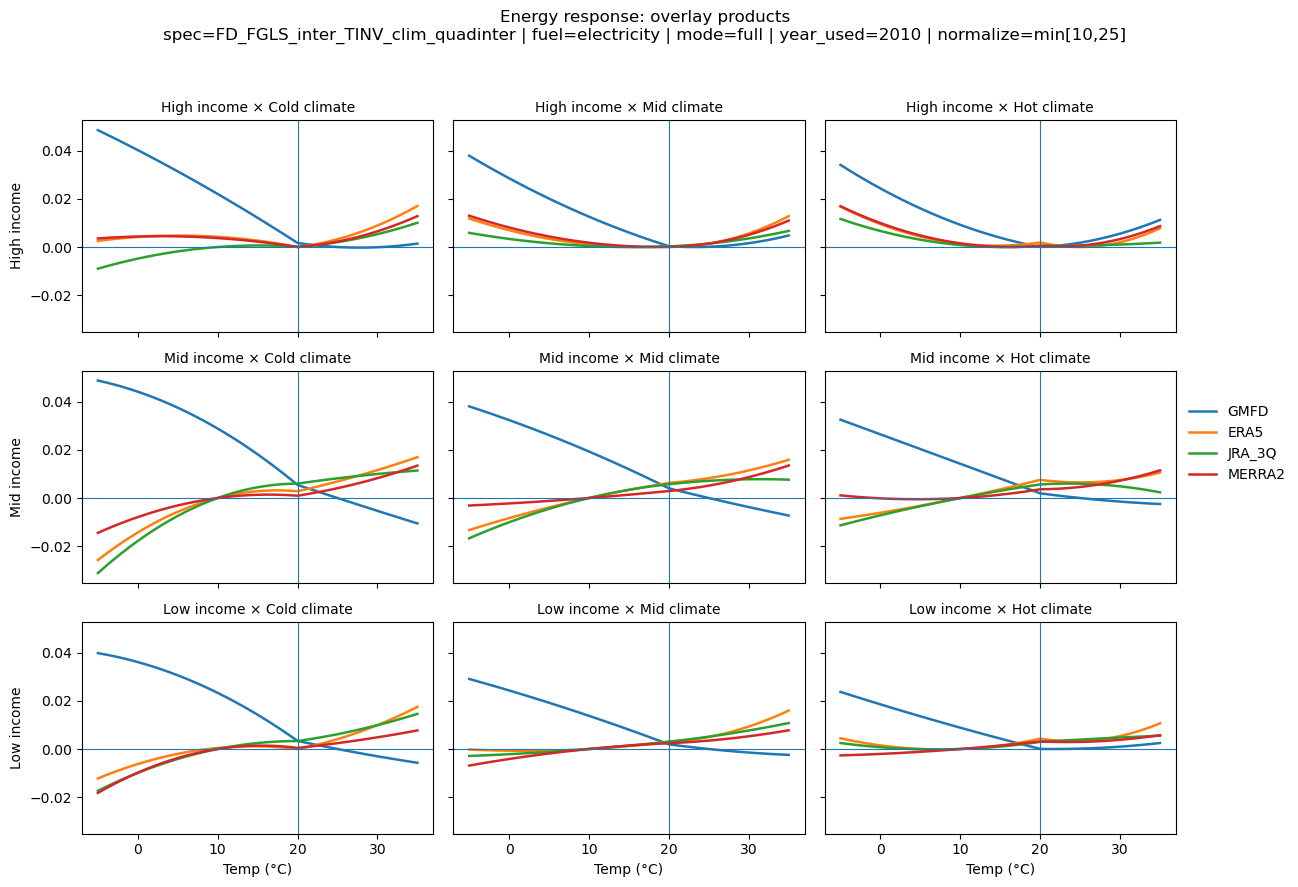

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ============================================================
# PATHS
# ============================================================
EU = Path("/user/ab5405/summeraliaclimate/code/energy_uncertainty")
STERD = EU / "data" / "regression" / "sters"

EDR = Path("/user/ab5405/summeraliaclimate/code/energy_consumption/energy_data_release_2021oct21/DATA/regression")
BREAK_DATA = EDR / "break_data_TINV_clim.dta"

# ============================================================
# SETTINGS
# ============================================================
PRODUCTS = ["GMFD", "ERA5", "JRA_3Q", "MERRA2"]
FUEL = "electricity"               # "electricity" or "other_energy"
IND_F = 1

MODEL_STEM = "FD_FGLS_inter_TINV_clim_quadinter"

T = np.arange(-5, 36, 1.0)
ABOVE20 = (T >= 20).astype(float)
BELOW20 = (T < 20).astype(float)

NORMALIZE_MIN_10_25 = True
SLICE_MIN, SLICE_MAX = 10, 25

# Choose what you want:
#   "full" = matches Stata quadinter figure logic (uses year and year^2)
#   "baseline" = excludes year and year^2 blocks
PLOT_MODE = "full"

YEAR_USED = 2010 

OUTDIR = EU / "figures" / "python_compare"
OUTDIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# HELPERS
# ============================================================
def must_exist(p: Path, label="file"):
    if not p.exists():
        raise FileNotFoundError(f"Missing {label}: {p}")

def read_coeff_csv(path: Path) -> pd.Series:
    df = pd.read_csv(path)
    if not {"parm", "beta"}.issubset(df.columns):
        raise ValueError(f"Expected parm,beta in {path}, got {df.columns.tolist()}")
    parm = df["parm"].astype(str).str.strip()   # <<< IMPORTANT
    beta = df["beta"].astype(float)
    return pd.Series(beta.values, index=parm.values)

def ibar_from_breakdata(bd: pd.DataFrame, fuel: str) -> float:
    maxcol = f"maxInc_largegpid_{fuel}"
    flagcol = f"largegpid_{fuel}"
    return float(bd.loc[bd[flagcol] == 1, maxcol].max())

def prep_income_map(bd: pd.DataFrame):
    inc_by_lg = bd.groupby("tgpid")["avgInc_tgpid"].mean().to_dict()
    return {int(k): float(v) for k, v in inc_by_lg.items()}

def prep_climate_maps(bd: pd.DataFrame):
    cdd_by_tr = bd.groupby("tpid")["avgCDD_tpid"].mean().to_dict()
    hdd_by_tr = bd.groupby("tpid")["avgHDD_tpid"].mean().to_dict()
    return ({int(k): float(v) for k, v in cdd_by_tr.items()},
            {int(k): float(v) for k, v in hdd_by_tr.items()})

def normalize_curve(y: np.ndarray) -> np.ndarray:
    if not NORMALIZE_MIN_10_25:
        return y
    win = (T >= SLICE_MIN) & (T <= SLICE_MAX)
    return y - np.min(y[win])

def parm_candidates(pg: int, indf: int, term: str, product: str) -> list[str]:
    # Try with suffix and without; also "co." vs "c."
    return [
        f"c.indp{pg}#c.indf{indf}#c.{term}_{product}",
        f"c.indp{pg}#c.indf{indf}#c.{term}",
        f"co.indp{pg}#co.indf{indf}#co.{term}_{product}",
        f"co.indp{pg}#co.indf{indf}#co.{term}",
    ]

def resolve_name(coef_index: pd.Index, pg: int, indf: int, term: str, product: str):
    # exact match first
    for nm in parm_candidates(pg, indf, term, product):
        if nm in coef_index:
            return nm
    return None

def build_design_quadinter(
    coef_index: pd.Index,
    *,
    fuel: str,
    product: str,
    subInc: float,
    subCDD: float,
    subHDD: float,
    ibar: float,
    year_used: int,
    indf: int,
    plot_mode: str,
):
    """
    plot_mode:
      - "full": match Stata quadinter figure logic (includes year and year^2 blocks)
      - "baseline": exclude year/year^2 blocks entirely (form comparisons)
    """
    pg = 1 if fuel == "electricity" else 2
    ig = 2 if subInc > ibar else 1
    deltacut = float(subInc - ibar)

    y = float(year_used)
    y2 = y * y

    names, cols = [], []

    for k in [1, 2]:
        Tk = T ** k
        base = Tk - (20.0 ** k)
        below = (20.0 ** k) - Tk

        # core terms
        nm_temp = resolve_name(coef_index, pg, indf, f"FD_temp{k}", product)
        nm_cdd  = resolve_name(coef_index, pg, indf, f"FD_cdd20_TINVtemp{k}", product)
        nm_hdd  = resolve_name(coef_index, pg, indf, f"FD_hdd20_TINVtemp{k}", product)
        nm_dc1  = resolve_name(coef_index, pg, indf, f"FD_dc1_lgdppc_MA15I{ig}temp{k}", product)

        if nm_temp:
            names.append(nm_temp); cols.append(base)
        if nm_cdd:
            names.append(nm_cdd); cols.append(ABOVE20 * subCDD * base)
        if nm_hdd:
            names.append(nm_hdd); cols.append(BELOW20 * subHDD * below)
        if nm_dc1:
            names.append(nm_dc1); cols.append(deltacut * base)

        if plot_mode == "full":
            # year and year^2 blocks (quadinter)
            nm_yt    = resolve_name(coef_index, pg, indf, f"FD_yeartemp{k}", product)
            nm_dc1y  = resolve_name(coef_index, pg, indf, f"FD_dc1_lgdppc_MA15yearI{ig}temp{k}", product)
            nm_y2t   = resolve_name(coef_index, pg, indf, f"FD_year2temp{k}", product)
            nm_dc1y2 = resolve_name(coef_index, pg, indf, f"FD_dc1_lgdppc_MA15year2I{ig}temp{k}", product)

            if nm_yt:
                names.append(nm_yt); cols.append(y * base)
            if nm_dc1y:
                names.append(nm_dc1y); cols.append(deltacut * y * base)
            if nm_y2t:
                names.append(nm_y2t); cols.append(y2 * base)
            if nm_dc1y2:
                names.append(nm_dc1y2); cols.append(deltacut * y2 * base)

    if not cols:
        raise RuntimeError(f"No plotting terms resolved for {product}. Check coefficient naming.")
    return np.column_stack(cols), names

# ============================================================
# LOAD break_data + maps
# ============================================================
must_exist(BREAK_DATA, "break_data")
bd = pd.read_stata(BREAK_DATA)

ibar = ibar_from_breakdata(bd, FUEL)
inc_by_lg = prep_income_map(bd)
cdd_by_tr, hdd_by_tr = prep_climate_maps(bd)

inc_label  = {1: "Low income", 2: "Mid income", 3: "High income"}
clim_label = {1: "Hot climate", 2: "Mid climate", 3: "Cold climate"}  # tpid ordering

# ============================================================
# PRELOAD COEFFICIENTS
# ============================================================
coefs = {}
for prod in PRODUCTS:
    coef_path = STERD / f"{MODEL_STEM}_{prod}_coeff.csv"
    must_exist(coef_path, f"{prod} coeff")
    coefs[prod] = read_coeff_csv(coef_path)

# ============================================================
# PLOT 3x3 OVERLAY
# ============================================================
fig, axes = plt.subplots(3, 3, figsize=(13, 9), sharex=True, sharey=True)
fig.suptitle(
    f"Energy response: overlay products\n"
    f"spec={MODEL_STEM} | fuel={FUEL} | mode={PLOT_MODE} | year_used={YEAR_USED} | normalize=min[{SLICE_MIN},{SLICE_MAX}]",
    y=0.98
)

row_order = [3, 2, 1]   # high -> mid -> low income (matches paper-style layout)
col_order = [3, 2, 1]   # hot -> mid -> cold climate  <<< FIXED

for r, lg in enumerate(row_order):
    for c, tr in enumerate(col_order):
        ax = axes[r, c]
        subInc = inc_by_lg[lg]
        subCDD = cdd_by_tr[tr]
        subHDD = hdd_by_tr[tr]

        for prod in PRODUCTS:
            coef = coefs[prod]
            X, names = build_design_quadinter(
                coef.index,
                fuel=FUEL, product=prod,
                subInc=subInc, subCDD=subCDD, subHDD=subHDD,
                ibar=ibar, year_used=YEAR_USED, indf=IND_F,
                plot_mode=PLOT_MODE,
            )
            beta = coef.loc[names].values
            y = normalize_curve(X @ beta)
            ax.plot(T, y, linewidth=1.8, label=prod)

        ax.axhline(0, linewidth=0.8)
        ax.axvline(20, linewidth=0.8)

        ax.set_title(f"{inc_label[lg]} × {clim_label[tr]}", fontsize=10)

        if c == 0:
            ax.set_ylabel(inc_label[lg], fontsize=10)
        if r == 2:
            ax.set_xlabel("Temp (°C)", fontsize=10)

# legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", frameon=False)
plt.tight_layout(rect=[0, 0, 0.92, 0.95])

out = OUTDIR / f"overlay_lines_3x3_{MODEL_STEM}_{FUEL}_{PLOT_MODE}_year{YEAR_USED}.pdf"
fig.savefig(out)
print("Saved:", out)

plt.show()
